In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
from matplotlib.colors import PowerNorm

In [ ]:
from basenet import BaseNetDatabase
from cosenet import CoSeNet as CorrelationSolver

In [63]:
with open('../data/regressors.json') as f:
    performance = json.load(f)
REG_2_TYPE = {
    'LinearRegression': 'QP-based',
    'Ridge': 'QP-based',
    'Lasso': 'QP-based',
    'ElasticNet': 'QP-based',
    'BayesianRidge': 'QP-based',
    'LassoLars': 'QP-based',
    'OrthogonalMatchingPursuit': 'QP-based',
    'svd': 'QP-based',
    'SVR': 'QP-based',
    'LinearSVR': 'QP-based',

    'cnn': 'Backpropagation',
    'mlp': 'Backpropagation',

    'DecisionTreeRegressor': 'Ensemble',
    'RandomForestRegressor': 'Ensemble',
    'AdaBoostRegressor': 'Ensemble',
    'GradientBoostingRegressor': 'Ensemble',
    'ExtraTreesRegressor': 'Ensemble',
    'ExtraTreeRegressor': 'Ensemble',
}
REG_2_SHORT = {
    'LinearRegression': 'LR',
    'Ridge': 'Ridge',
    'Lasso': "Lasso",
    'ElasticNet': 'EN',
    'BayesianRidge': 'BR',
    'LassoLars': 'LL',
    'OrthogonalMatchingPursuit': 'OMP',
    'svd': 'SVD',
    'SVR': 'SVR',
    'LinearSVR': 'LSVR',

    'cnn': 'CNN',
    'mlp': 'MLP',

    'DecisionTreeRegressor': 'DTR',
    'RandomForestRegressor': 'RFR',
    'AdaBoostRegressor': 'AR',
    'GradientBoostingRegressor': 'GBR',
    'ExtraTreesRegressor': 'ETR',
    'ExtraTreeRegressor': 'RTsR',
}

In [64]:
dictionary_to_df = list()
for variance, models in performance.items():
    for model_name, model_performance in models.items():
        if '_scaled' in model_name:
            model_name = model_name.split('_scaled')[0]
            model_name_mod = REG_2_SHORT[model_name] + ' std.'
        else:
            model_name_mod = REG_2_SHORT[model_name]
        dictionary_to_df.append({
            'variance': int(variance.split('_')[1]) / 10,
            'throughput': int(variance.split('_')[0]),
            'MSE': model_performance['mse'] if model_performance['mse'] < 1 else 1,
            'MAE': model_performance['mae'] if model_performance['mae'] < 1 else 1,
            '1 - R2': abs(1 - model_performance['r2']) if 0 < model_performance['r2'] < 1 else 1,
            'WindowDiff': model_performance['wd'],
            'Model': model_name_mod,
            'Optimization type': REG_2_TYPE[model_name.replace(' std.', '')]
        })
performance_df_original = pd.DataFrame(dictionary_to_df)
performance_df = performance_df_original[[' std' not in mod for mod in performance_df_original['Model']]]
performance_df_original.head(None)

,variance,throughput,MSE,MAE,1 - R2,WindowDiff,Model,Optimization type
0,0.0,8,5.577749e-13,4.348296e-07,4.472422e-12,0.000000,LR,QP-based
1,0.0,8,3.735153e-13,3.411818e-07,2.984279e-12,0.000000,LR std.,QP-based
2,0.0,8,1.098513e-01,2.178827e-01,8.751529e-01,0.468233,Lasso,QP-based
3,0.0,8,1.098513e-01,2.178827e-01,8.751529e-01,0.468233,Lasso std.,QP-based
4,0.0,8,5.983090e-08,6.288424e-05,4.784456e-07,0.000000,Ridge,QP-based
...,...,...,...,...,...,...,...,...
607,0.5,32,1.128859e-01,2.204355e-01,6.584961e-01,0.317684,MLP,Backpropagation
608,0.5,32,1.093930e-01,2.613906e-01,6.584961e-01,0.301333,SVD,QP-based
609,0.5,32,9.137745e-02,1.684718e-01,1.000000e+00,0.201702,CNN std.,Backpropagation
610,0.5,32,1.379312e-01,1.719509e-01,1.000000e+00,0.253643,MLP std.,Backpropagation


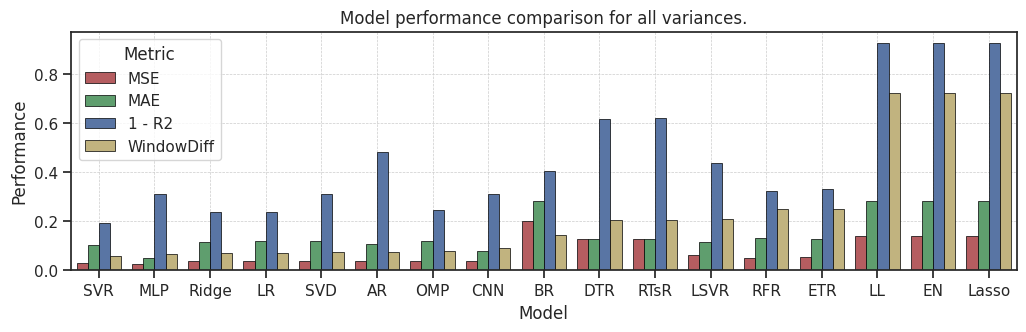

In [402]:
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.set(rc={'figure.figsize':(3.87 * 2.1,6.27)})
sns.set(rc={'figure.figsize':(12.2, 3.1)})
sns.set_palette("colorblind")
sns.set_style("ticks")
mean_performance = performance_df.groupby(['Model', 'Optimization type']).mean(numeric_only=True).sort_values('WindowDiff').reset_index().drop(['variance', 'throughput', 'Optimization type'], axis=1)
mean_performance = pd.melt(mean_performance, id_vars='Model', var_name="Metric", value_name="value")
g = sns.barplot(x="Model", y="value", data=mean_performance, errorbar=None, hue='Metric', palette=['r', 'g', 'b', 'y'], width=0.8, edgecolor='black', linewidth=0.5)
plt.legend(title='Metric', loc='upper left', labels=['MSE', 'MAE', '1 - R2', 'WindowDiff'])
# plt.legend([], [], frameon=False)
# g.set(xlabel='Performance', ylabel=None)
# g.set(ylim=(0, 1.05))
# g.set(xlim=(None, None))
# # g.set(yticklabels=mean_performance['Model'].unique())
# g.set(yticklabels=[])
# g.set(yticks=np.arange(0, len(mean_performance['Model'].unique())))
g.set(xlabel='Model', ylabel='Performance')
g.grid(True, linestyle='--', linewidth=0.5)
g.set_title(f'Model performance comparison for all variances.')
plt.savefig(f'../render/model_performance_comparison_overall.pdf', bbox_inches='tight')
plt.show()
order = mean_performance['Model'].unique().tolist()

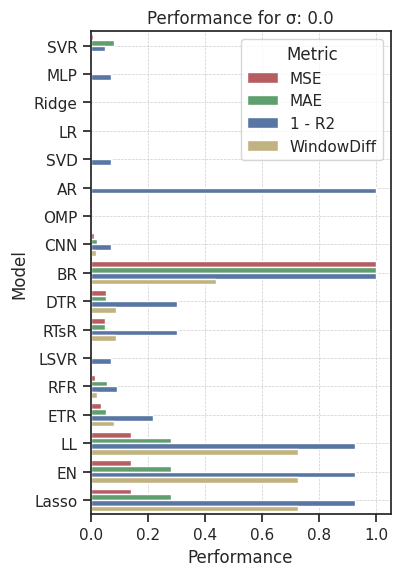

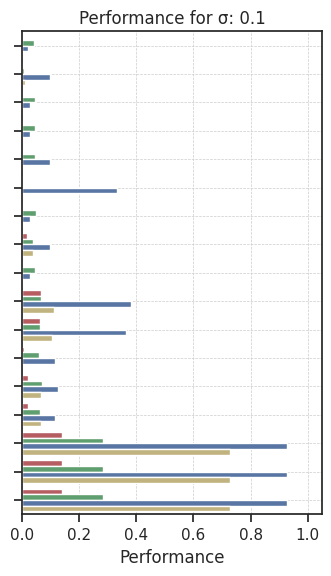

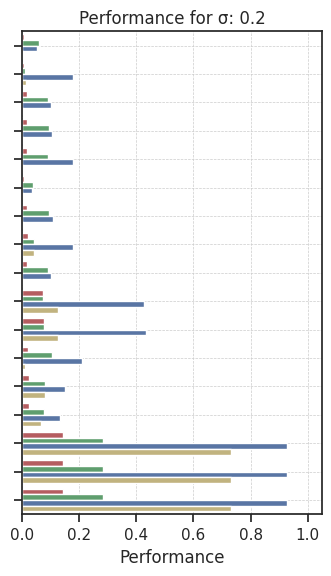

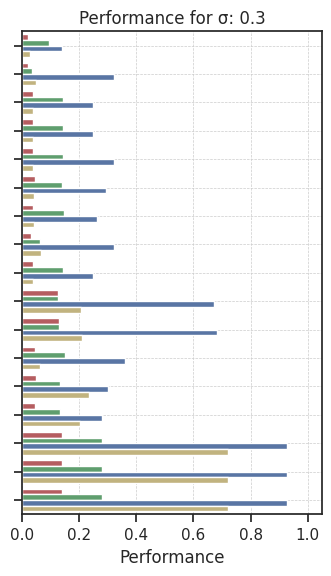

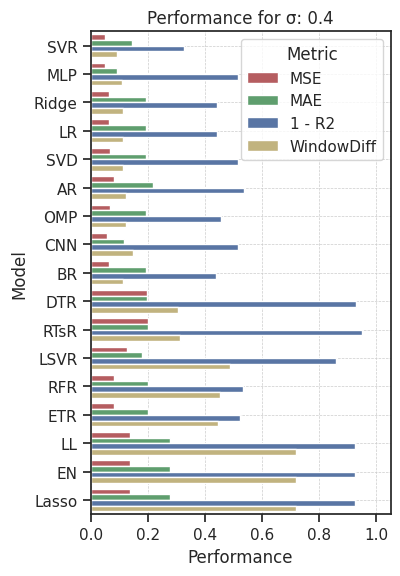

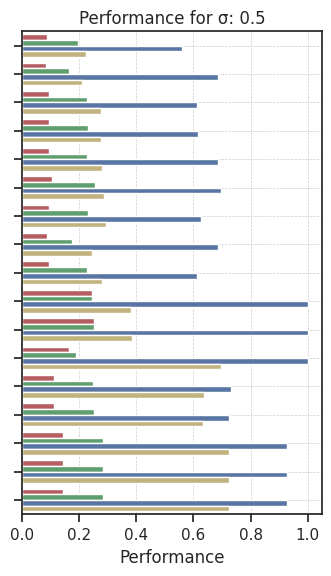

In [66]:
# Seaborn barplot by models:
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set(rc={'figure.figsize':(3.87,6.27)})
sns.set_palette("colorblind")
sns.set_style("ticks")
# We plot the performance of each model for each variance and provide a hue for the throughput. We also provide a legend for the throughput.
for ix, variance in enumerate(performance_df['variance'].unique()):
    mean_performance = performance_df[performance_df['variance'] == variance].groupby(['Model', 'Optimization type']).mean(numeric_only=True).reset_index().drop(['variance', 'throughput', 'Optimization type'], axis=1).sort_values(by='Model', key=lambda x: x.map(order.index))
    mean_performance = pd.melt(mean_performance, id_vars='Model', var_name="Metric", value_name="value")
    g = sns.barplot(x="value", y="Model", data=mean_performance, errorbar=None, hue='Metric', palette=['r', 'g', 'b', 'y'], width=0.8)
    if not ix % 4:
        g.set(xlabel='Performance', ylabel='Model')
        g.set(yticklabels=mean_performance['Model'].unique())
    else:
        plt.legend([], [], frameon=False)
        g.set(xlabel='Performance', ylabel=None)
        g.set(yticklabels=list())
    g.set(xlim=(0, 1.05))
    g.set(ylim=(None, None))
    g.set(yticks=np.arange(0, len(mean_performance['Model'].unique())))
    g.grid(True, linestyle='--', linewidth=0.5)
    g.set_title(f'Performance for σ: {variance}')
    plt.savefig(f'../render/model_performance_comparison_{variance}.pdf', bbox_inches='tight')
    plt.show()

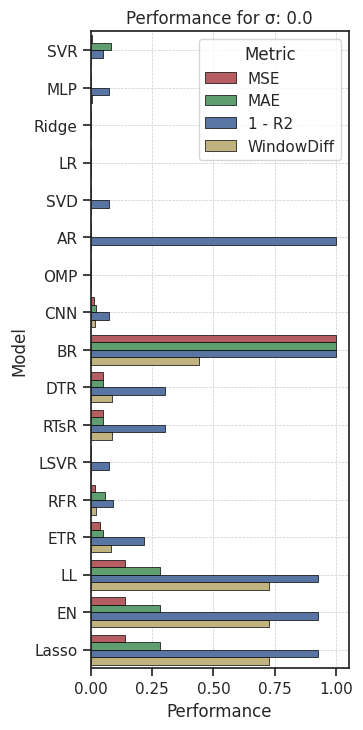

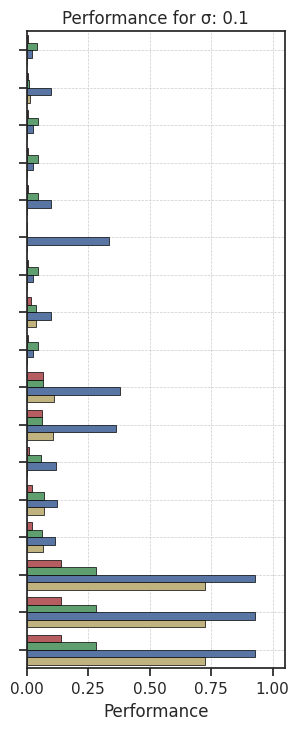

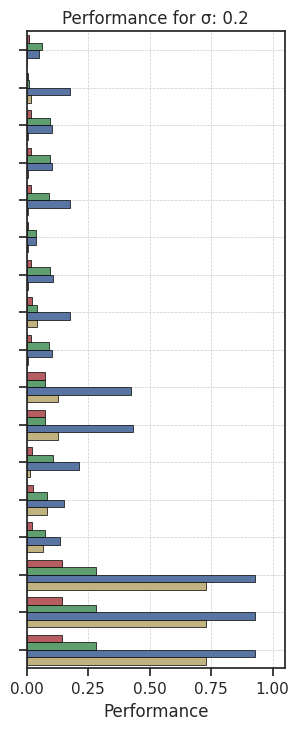

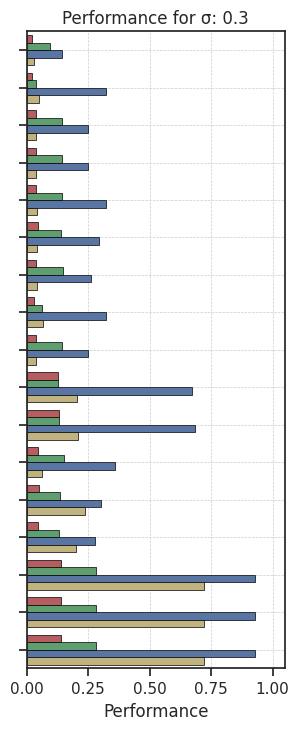

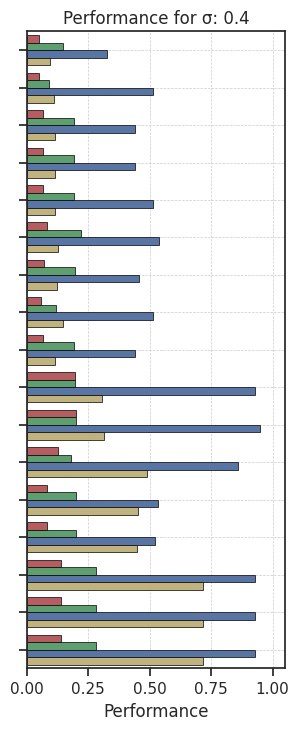

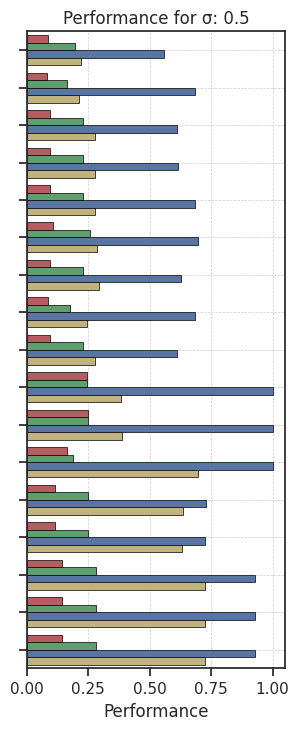

In [67]:
# Seaborn barplot by models:
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set(rc={'figure.figsize':(3.87 * 0.86,8.27)})
sns.set_palette("colorblind")
sns.set_style("ticks")
# We plot the performance of each model for each variance and provide a hue for the throughput. We also provide a legend for the throughput.
for ix, variance in enumerate(performance_df['variance'].unique()):
    mean_performance = performance_df[performance_df['variance'] == variance].groupby(['Model', 'Optimization type']).mean(numeric_only=True).reset_index().drop(['variance', 'throughput', 'Optimization type'], axis=1).sort_values(by='Model', key=lambda x: x.map(order.index))
    mean_performance = pd.melt(mean_performance, id_vars='Model', var_name="Metric", value_name="value")
    g = sns.barplot(x="value", y="Model", data=mean_performance, errorbar=None, hue='Metric', palette=['r', 'g', 'b', 'y'], width=0.8, edgecolor='black', linewidth=0.5)
    if not ix % 6:
        g.set(xlabel='Performance', ylabel='Model')
        g.set(yticklabels=mean_performance['Model'].unique())
    else:
        plt.legend([], [], frameon=False)
        g.set(xlabel='Performance', ylabel=None)
        g.set(yticklabels=list())
    g.set(xlim=(0, 1.05))
    g.set(ylim=(None, None))
    g.set(yticks=np.arange(0, len(mean_performance['Model'].unique())))
    g.grid(True, linestyle='--', linewidth=0.5)
    g.set_title(f'Performance for σ: {variance}')
    plt.savefig(f'../render/model_performance_comparison_{variance}.pdf', bbox_inches='tight')
    plt.show()

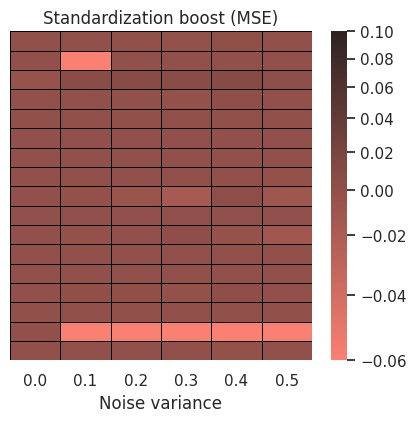

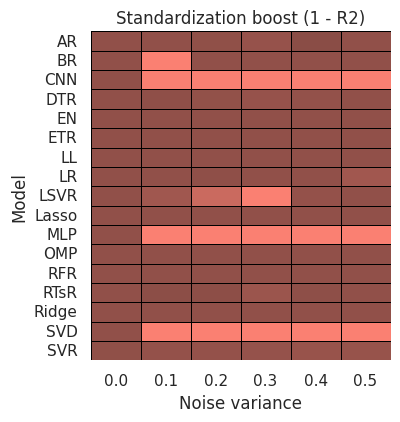

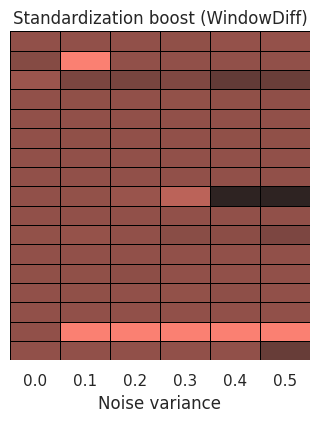

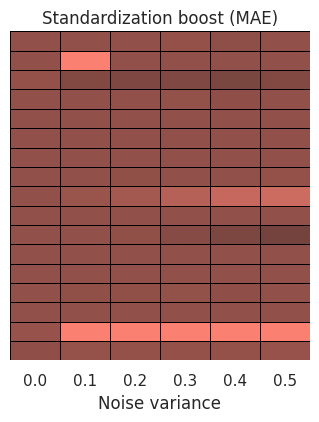

In [79]:
# Boxplot the boost of standarization:
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set(rc={'figure.figsize':(3.87,4.27)})
sns.set_palette("colorblind")
sns.set_style("ticks")

boosts = {'Model': list(), 'Metric': list(), 'Boost': list(), 'Variance': list()}
for ix, variance in enumerate(performance_df_original['variance'].unique()):
    mean_performance = performance_df_original[performance_df_original['variance'] == variance].groupby(['Model', 'Optimization type']).mean(numeric_only=True).reset_index().drop(['variance', 'throughput', 'Optimization type'], axis=1)
    for model in mean_performance['Model'].unique():
        if ' std' not in model:
            for metric in ['MSE', '1 - R2', 'WindowDiff', 'MAE']:
                boosts['Model'].append(model)
                boosts['Metric'].append(metric)
                boosts['Variance'].append(variance)
                boosts['Boost'].append(-mean_performance.loc[mean_performance['Model'] == model + ' std.', metric].values[0] + mean_performance.loc[mean_performance['Model'] == model, metric].values[0])
boosts_df = pd.DataFrame(boosts)
# We create a heatmap of the boosts:
for ix, metric in enumerate(['MSE', '1 - R2', 'WindowDiff', 'MAE']):
    if ix:
        sns.set(rc={'figure.figsize':(3.87,4.27)})
    else:
        sns.set(rc={'figure.figsize':(4.87,4.27)})
    metric_df = boosts_df[boosts_df['Metric'] == metric].drop(['Metric'], axis=1).pivot(index='Model', columns='Variance', values='Boost')
    g = sns.heatmap(metric_df, cmap=sns.color_palette('dark:salmon_r', as_cmap=True), linewidths=0.5, cbar=ix==0, linecolor='black', norm=PowerNorm(gamma=0.6, vmin=-0.05, vmax=0.1, clip=False))
    if ix in (0, 2, 3):
        g.set(yticklabels=[])
        g.set(xlabel='Noise variance', ylabel=None)
    else:
        g.set(xlabel='Noise variance', ylabel='Model')
    # g.set(xticklabels=boosts_df['Variance'].unique())
    # g.set(yticks=np.arange(0, len(boosts_df['Model'].unique())))
    # g.set(xticks=np.arange(0, len(boosts_df['Variance'].unique())))
    g.grid(True, linestyle='--', linewidth=0.5)
    g.set_title(f'Standardization boost ({metric})')
    plt.savefig(f'../render/boost_{metric}.pdf', bbox_inches='tight')
    plt.show()

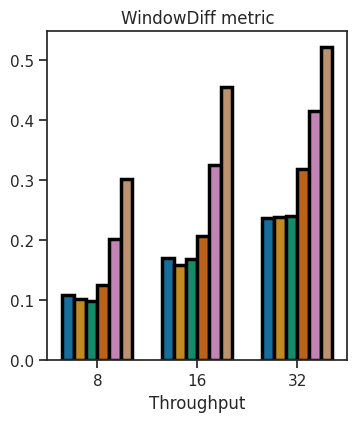

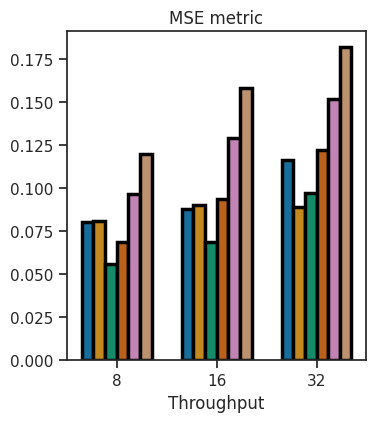

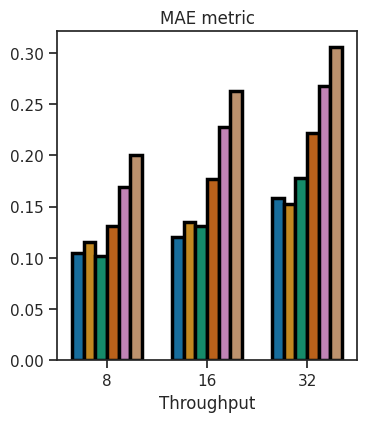

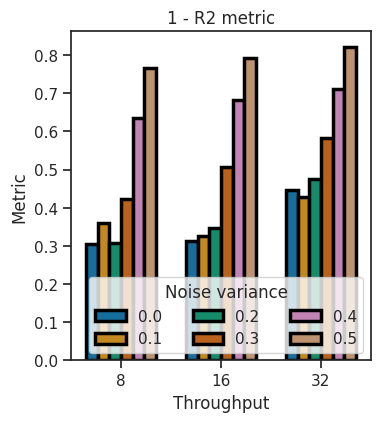

In [69]:
# We group all the thougputs in one to see in the dataframe the overall performance given one thoughput.
throughputs = performance_df_original['throughput'].unique()
tputs_df = performance_df_original.drop(['Optimization type'], axis=1).groupby(['throughput', 'variance']).mean(numeric_only=True).reset_index()
# We plot the MSE, MAE, 1 - R2 and WindowDiff for each throughput:
sns.set(style="white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set(rc={'figure.figsize':(3.87,4.27)})
sns.set_style("ticks")
for ix, metric in enumerate(('WindowDiff', 'MSE', 'MAE', '1 - R2')):
    g = sns.barplot(x='throughput', y=metric, data=tputs_df, hue='variance', palette='colorblind', linewidth=2.5, edgecolor='black', width=0.7)
    g.set_title(f'{metric} metric')
    if ix == 3:
        g.legend(loc='lower right', title='Noise variance', ncol=3)
        g.set(xlabel='Throughput', ylabel='Metric')
    else:
        g.legend([], [], frameon=False)
        g.set(xlabel='Throughput', ylabel=None)
    plt.savefig(f'../render/throughput_{metric}.pdf', bbox_inches='tight')
    plt.show()

In [44]:
def transferability(df: pd.DataFrame, model__name: str):
    current_df = df[df['model'] == model__name].groupby(['inner', 'throughput']).mean(numeric_only=True).reset_index().drop(['target'], axis=1)
    current_df['inner'] = current_df['inner'].div(10)
    return current_df.melt(id_vars=['inner', 'throughput'], value_vars=['wd', 'mse'], var_name='metric', value_name='value')

def dash_grid(g_, values, col='orange'):
    axes = g_.fig.axes
    x = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    y = np.ones(6)
    for axes, value in zip(axes, values):
        axes.plot(x, value * y, color=col, linewidth=1, linestyle='--')
    return g_

In [45]:
with open('../data/transfer.json', 'r') as f:
    transferability_df = json.load(f)
    transferability_df = pd.DataFrame(transferability_df)
mlp_df = transferability(transferability_df, 'mlp')
rid_df = transferability(transferability_df, 'ridge')
svr_df = transferability(transferability_df, 'svr')

/home/sugar137/Desktop/cormat/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/home/sugar137/Desktop/cormat/venv/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth', 'clip_on'
  cset = contour_func(
/home/sugar137/Desktop/cormat/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/home/sugar137/Desktop/cormat/venv/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth', 'clip_on'
  cset = contour_func(
/home/sugar137/Desktop/cormat/venv/lib/p

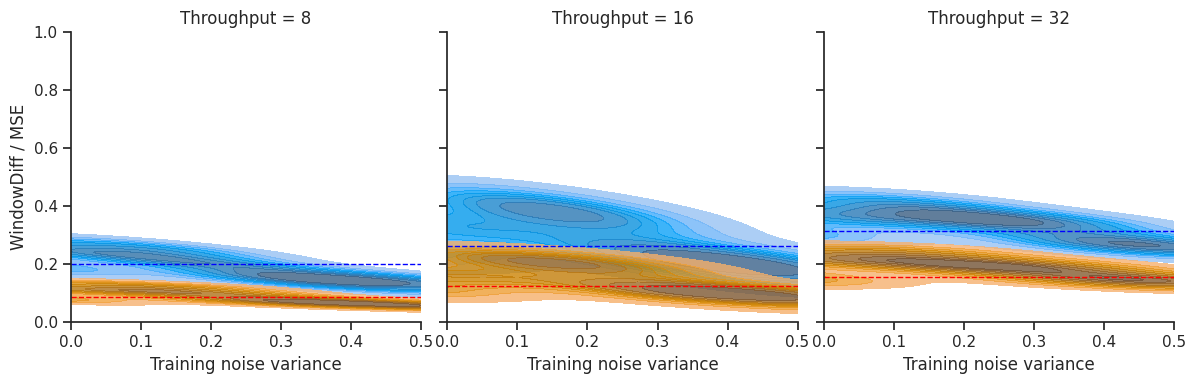

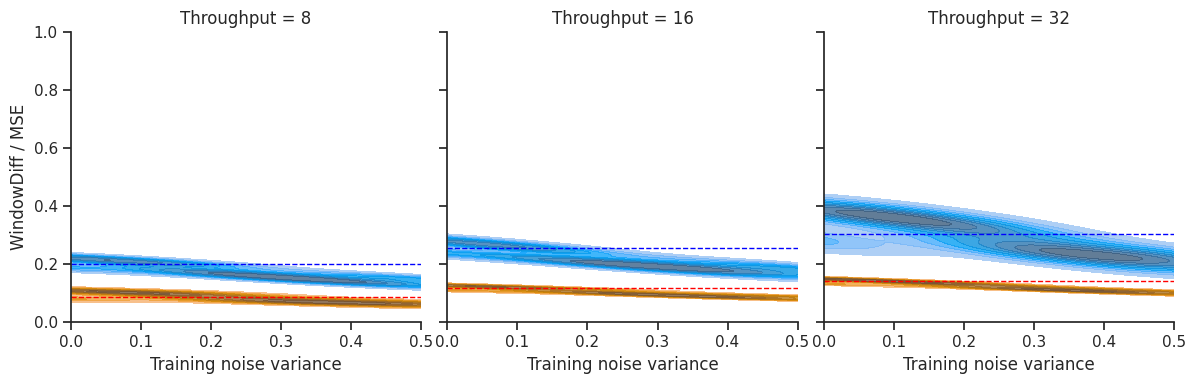

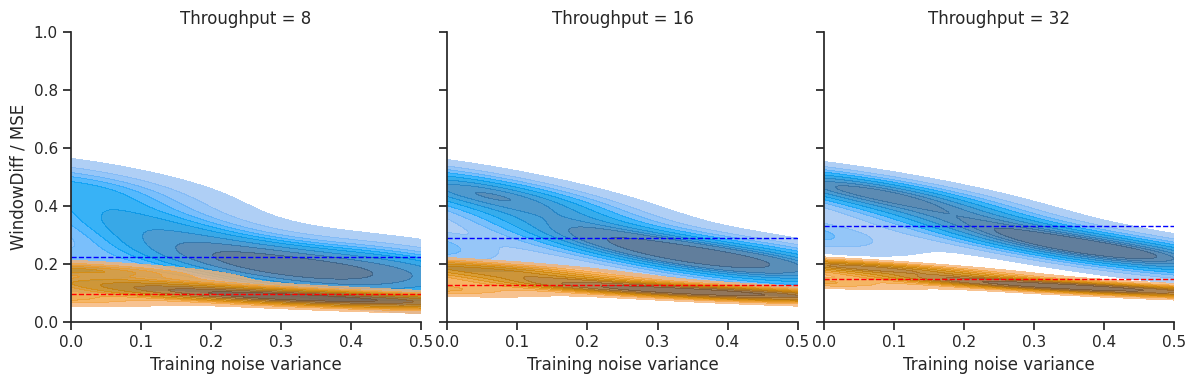

In [48]:
# We create a ridge plot of the transferability:
sns.set(style="white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set(rc={'figure.figsize':(3.87,4.27)})
sns.set_style("ticks")
sns.set_palette("colorblind")
g = sns.FacetGrid(mlp_df, hue='metric', col='throughput', height=4, aspect=1).map(sns.kdeplot, 'inner', 'value', linewidth=2.5, clip_on=False, alpha=0.8, shade=True, bw_adjust=0.8, label='MLP')
g.set_titles(col_template='Throughput = {col_name}')
g.set_axis_labels('Training noise variance', 'WindowDiff / MSE')
g.set(xlim=(0, 0.5), ylim=(0, 1))

_ = mlp_df[mlp_df['inner'] == -0.1]
wd_met = _[_['metric'] == 'wd']['value'].values
mse_met = _[_['metric'] == 'mse']['value'].values
g = dash_grid(g, mse_met, col='red')
g = dash_grid(g, wd_met, col='blue')

g.savefig('../render/transferability_mlp.pdf', bbox_inches='tight')
g = sns.FacetGrid(svr_df, hue='metric', col='throughput', height=4, aspect=1).map(sns.kdeplot, 'inner', 'value', linewidth=2.5, clip_on=False, alpha=0.8, shade=True, bw_adjust=0.8)
g.set_titles(col_template='Throughput = {col_name}')
g.set_axis_labels('Training noise variance', 'WindowDiff / MSE')
g.set(xlim=(0, 0.5), ylim=(0, 1))

_ = svr_df[svr_df['inner'] == -0.1]
wd_met = _[_['metric'] == 'wd']['value'].values
mse_met = _[_['metric'] == 'mse']['value'].values
g = dash_grid(g, mse_met, col='red')
g = dash_grid(g, wd_met, col='blue')

g.savefig('../render/transferability_svr.pdf', bbox_inches='tight')
g = sns.FacetGrid(rid_df, hue='metric', col='throughput', height=4, aspect=1).map(sns.kdeplot, 'inner', 'value', linewidth=2.5, clip_on=False, alpha=0.8, shade=True, bw_adjust=0.8)
g.set_titles(col_template='Throughput = {col_name}')
g.set_axis_labels('Training noise variance', 'WindowDiff / MSE')
g.set(xlim=(0, 0.5), ylim=(0, 1))

_ = rid_df[rid_df['inner'] == -0.1]
wd_met = _[_['metric'] == 'wd']['value'].values
mse_met = _[_['metric'] == 'mse']['value'].values
g = dash_grid(g, mse_met, col='red')
g = dash_grid(g, wd_met, col='blue')

g.savefig('../render/transferability_rid.pdf', bbox_inches='tight')

In [49]:
def spiderplot(df, number_row, title):
    # number of variable
    categories = list(df)[0:3]
    _n = len(categories)
    my_palette = plt.cm.get_cmap("Set2", len(df.index))
    color = my_palette(number_row)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(_n) * 2 * np.pi for n in range(_n)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(1,3,number_row+1, polar=True)
    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    # Draw ylabels
    ax.set_rlabel_position(0)
    ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    plt.yticks(ticks, [str(tick) for tick in ticks], color="grey", size=7)
    plt.ylim(0,1)
    # Ind1
    values=df.loc[number_row].drop('Model').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    plt.title(title, size=12, color=color, y=1.1)

def one_spiderplot(df, palette):
    my_palette = plt.cm.get_cmap(palette, len(df.index))
    categories = list(df)[0:3]
    _n = len(categories)
    angles = [n / float(_n) * 2 * np.pi for n in range(_n)]
    angles += angles[:1]
    ax = plt.subplot(1 ,1 , 1, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [], color="grey", size=7)
    plt.ylim(0,1)

    values=df.loc[0].drop('Model').values.flatten().tolist()
    values += values[:1]
    ax.fill(angles, values, color=my_palette(0), alpha=0.4)
    values=df.loc[1].drop('Model').values.flatten().tolist()
    values += values[:1]
    ax.fill(angles, values, color=my_palette(1), alpha=0.4)
    values=df.loc[2].drop('Model').values.flatten().tolist()
    values += values[:1]
    ax.fill(angles, values, color=my_palette(2), alpha=0.4)

    values=df.loc[0].drop('Model').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=my_palette(0), linewidth=2, linestyle='solid')
    values=df.loc[1].drop('Model').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=my_palette(1), linewidth=2, linestyle='solid')
    values=df.loc[2].drop('Model').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=my_palette(2), linewidth=2, linestyle='solid')
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=7)
    plt.legend(['MLP', 'Ridge', 'SVR'], loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Qualitative model comparison.', size=12, color='black', y=1.1)


# Performance, speed, memory comparison.

/tmp/ipykernel_4101/1978681234.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap("Set2", len(df.index))
/tmp/ipykernel_4101/1978681234.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap("Set2", len(df.index))
/tmp/ipykernel_4101/1978681234.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap("Set2", len(df.index))
/tmp/ipykernel_4101/1978681234.py:31: MatplotlibDeprecationWarning: The get_

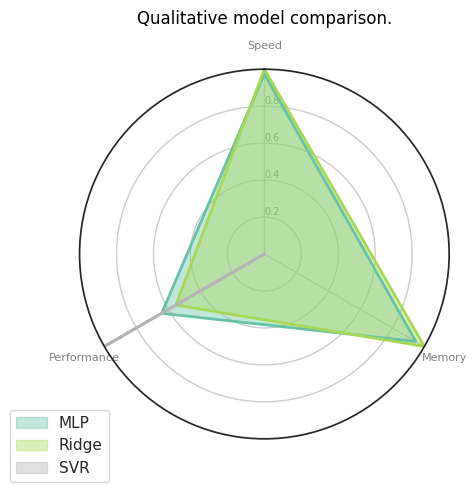

In [50]:
mlp_speed = (0.7761248410097323 + 0.8414203299907967 + 1.2618626239709556) / 3  # Seconds per 60 000 mat.
rid_speed = (0.01827864599181339 + 0.04934133595088497 + 0.15848324896069244) / 3  # seconds per 60 000 mat.
svr_speed = (23.175203430000693 + 390.7795837019803 + 3555.5856795319705) / 3  # Seconds per 60 000 mat.
mlp_speed = 1 - ((mlp_speed - rid_speed) / svr_speed) ** 0.5
rid_speed = 1 - ((rid_speed - rid_speed) / svr_speed) ** 0.5
svr_speed = 1 - ((svr_speed - rid_speed) / svr_speed) ** 0.5


mlp_memory = 1 - ((1363056 - 16873) / 469715993) ** 0.5
rid_memory = 1 - ((16873 - 16873) / 469715993) ** 0.5
svr_memory = 1 - ((469715993 - 16873) / 469715993) ** 0.5

mlp_performance = 1 - ((0.06684 - 0.05759) / 0.07203) ** 0.5
rid_performance = 1 - ((0.07203 - 0.05759) / 0.07203) ** 0.5
svr_performance = 1 - ((0.05759 - 0.05759) / 0.07203) ** 0.5

spider_df = pd.DataFrame([{'Speed': mlp_speed, 'Memory': mlp_memory, 'Performance': mlp_performance, 'Model': 'mlp'},
                          {'Speed': rid_speed, 'Memory': rid_memory, 'Performance': rid_performance, 'Model': 'ridge'},
                          {'Speed': svr_speed, 'Memory': svr_memory, 'Performance': svr_performance, 'Model': 'svr'}])
plt.figure(figsize=(24 * 0.6, 8 * 0.6))
for nrow, _ in enumerate(spider_df.index):
    spiderplot(spider_df, nrow, f"{spider_df['Model'][nrow]}\n".upper())
plt.savefig('../render/spiderplot.pdf', bbox_inches='tight')
one_spiderplot(spider_df, 'Set2')
plt.savefig('../render/spiderplot_overlap.pdf', bbox_inches='tight')

Now we perform a baseline comparison based on the simulation of the models.

In [2]:
with open('../data/baseline_comparison.json', 'rb') as f:
    baseline_comparison = json.load(f)
with open('../data/baseline_comparison_synth.json', 'rb') as f:
    baseline_comparison_synth = json.load(f)

In [3]:
blc = {bname: pd.DataFrame(baseline).mean() for bname, baseline in baseline_comparison.items()}
blc_synth = {bname: pd.DataFrame(baseline).mean() for bname, baseline in baseline_comparison_synth.items()}

In [7]:
to_keys = list()
to_dfs = list()
for key, item in blc.items():
    to_keys.append(key)
    to_dfs.append(item)
baseline_df = 100-100*pd.DataFrame(to_dfs, index=to_keys)[['mse', 'time']]
to_keys = list()
to_dfs = list()
for key, item in blc_synth.items():
    to_keys.append(key)
    to_dfs.append(item)
baseline_synth_df = 100-100*pd.DataFrame(to_dfs, index=to_keys)[['mse', 'time']]

In [5]:
with open('../data/our_results.json', 'rb') as f:
    our_results = json.load(f)
our_results_df = pd.DataFrame(our_results)
our_synth = our_results_df[our_results_df['synth'] == True]
our_real = our_results_df[our_results_df['synth'] == False]

In [6]:
perf_synth = 100 - 100 * our_synth['wd'].mean()
perf_wiki = 100 - 100 * our_real['wd'].mean()
perf_mse_synth = 100 - 100 * our_synth['mse'].mean()
perf_mse_wiki = 100 - 100 * our_real['mse'].mean()
times = our_results_df['time'].mean()

In [18]:
bndb = BaseNetDatabase.load('../data/wk/wikipedia_dataset_256.db')
matrix = bndb.xtest[:, :30, :30]
labels = bndb.ytest[:, :30]
solver = CorrelationSolver(throughput=16, model_path='../src/cosolver/pre-trained/ridge/16/5.pickle')
# Get random matrices:
random_matrices = list()
random_labels = list()
for _ in range(15):
    random_index = np.random.randint(matrix.shape[0])
    random_matrices.append(matrix[random_index])
    random_labels.append(labels[random_index])

In [19]:
random_predictions = solver.solve(random_matrices)[1]

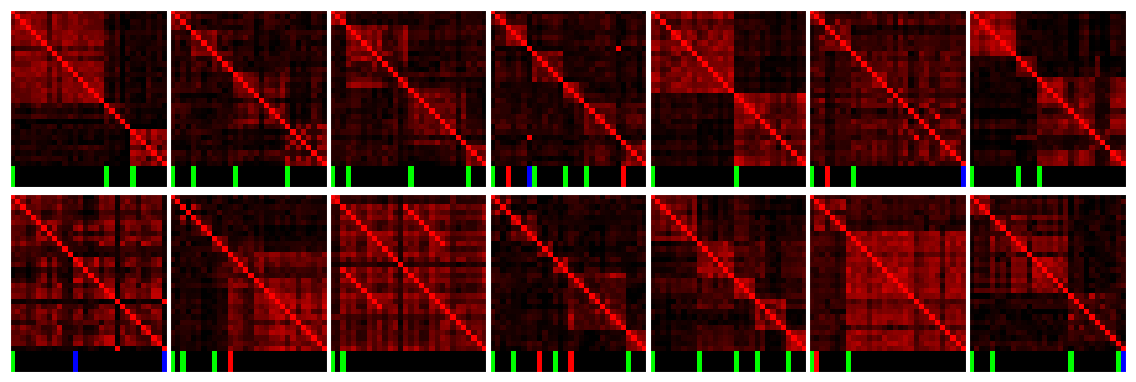

In [41]:
xax = 0
plt.figure(figsize=(24 * 0.6, 8 * 0.6))
plt.subplots_adjust(wspace=0.02, hspace=0)
for matrix, label, prediction in zip(random_matrices, random_labels, random_predictions):
    plt.subplot(2, 7, xax + 1)
    this_color_mat = np.concatenate([matrix, np.zeros(matrix.shape), np.zeros(matrix.shape)], axis=-1)
    _p = np.expand_dims(prediction, axis=-1)
    _l = np.expand_dims(label, axis=-1)
    _z = np.zeros(_l.shape)
    _o = np.ones(_l.shape)
    last_layer = np.concatenate([_l - _p, _l + _p - _o, _p - _l], axis=-1)
    expose_mat = np.concatenate([this_color_mat, 4 * [last_layer]], axis=0)
    plt.imshow(expose_mat)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    xax += 1
    if xax == 14:
        break
plt.savefig('../render/example_predictions.pdf', bbox_inches='tight')
plt.show()

In [ ]:
with open('../src/cosolver/pre-trained/ridge/8/5.pickle') as file:
    inner_model = pickle.load(file)
overall_model = CorrelationSolver(throughput=8, model_path='../src/cosolver/pre-trained/ridge/8/5.pickle')

db_32 = BaseNetDatabase.load('../data/sym/32.db')
samples = db_32.xtest
solutions = db_32.ytest
predictions = list()

split_samples = list()
split_solutions = list()
split_predictions = list()
for sample, solution in zip(samples, solutions):
    m1 = np.ceil(sample.shape[0] / 4) - 1
    _split_samples = list()
    _split_solutions = list()
    _split_predictions = list()
    for _ in range(m1):
        current_sample = sample[_ * 4:_ * 4 + 8, _ * 4:_ * 4 + 8]
        _split_samples.append(current_sample)
        current_sol = solution[_ * 4:_ * 4 + 8]
        current_sol[0] = 1
        _split_solutions.append(current_sol)
        _split_predictions.append(inner_model.predict(current_sample))
    split_samples.append(_split_samples)
    split_solutions.append(_split_solutions)
    split_predictions.append(_split_predictions)
    predictions.append(overall_model.solve([sample])[1])